# Packages: minimize for better structure

In [216]:
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib.lines import Line2D
warnings.filterwarnings('ignore')

# Usage of Epochs to classify Responders/Non Responder

This is a notebook to map and structure the use of classifying nearby epochs, in order to make more accurate classifications. Hence, it does a sandbox for epoch-training.

But what is the goal? We want to predict consciousness by including as much data as possible. 

Main Idea: (aim -> individual level)
- Initialize the data
- Use epochs? Maybe this should be during the training proccess or data initialization?
- These epochs are classified to be responder or non responder. 
  - How is this done? Maybe start with a simple architecture so it trains fast for testing
  - It has to be unsupervised. Labels aren't given yet.
  - These assigned labels has to go through the threshold in order to pass. (visualize this to evaluate)
        - A value is chosen to be set as a treshold for how many seconds from literature
        - It could be supervised. By running unsupervised and using the approximated labels to train a model.


# Step 1: Initialize the data, and make sure this is done correct:
Explanation:

To begin, a folder directory and path are specified to access the files. These paths are joined using the os.path.join() function to handle the paths correctly and ensure they point to the right destination. Empty arrays are initialized for storing values. For instance, the patient_numbers list stores the IDs for each patient, which could be formatted like p1, p2, and so on.

A for loop is then used to iterate over each file in the directory, which corresponds to iterating through each patient. The filenames are processed using the os.fsdecode() function, and the patient number is extracted by splitting the filename based on underscores and selecting the first element. The patient number is then added to the patient_numbers array that was initialized earlier.

Next, the full directory of each patient file is constructed by joining the base path with the specific filename. This ensures that the data can be properly accessed. The data itself is read from the CSV files using pd.read_csv(), as the files are in CSV format.

After loading the data, some preprocessing steps are applied. Column names are adjusted, and any text-based attributes are converted into numerical values for easier handling. A set of specific columns is chosen for standardization, which is done using the StandardScaler from sklearn. This step ensures that features are on the same scale, preventing large values from dominating the training process. By standardizing, the mean of each column is set to 0, and the standard deviation is set to 1, ensuring uniformity in the dataset.


In [217]:
path = 'CSV_features_NEW'
folder = 'C:\\Users\\RJEN0307\\Desktop\\Bachelorprojekt\\Bachelor_project_2024\\'

full_path = os.path.join(folder, path)



patient_numbers = []
patient_data = {}

for file in os.listdir(full_path):
    filename = os.fsdecode(file)
    patient_number = filename.split('_')[0]  # This will give 'p3' from 'p3_features.csv'
    patient_numbers.append(patient_number)
    patient_file_dir = os.path.join(full_path, filename)
    data = pd.read_csv(patient_file_dir)
    data.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
    data['Event'] = data['Event'].map({'R': 0, 'M': 1, 'F': 2})
    standarize_list = ['PSD Delta', 'PSD Delta_N', 'PSD Theta', 'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N', 'PSD Beta', 'PSD Beta_N', 'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Mean RR', 'Std RR', 'Mean HR', 'Std HR', 'Min HR', 'Max HR', 'Freq_Slope mean', 'Freq_Slope std']

    sklearn.preprocessing.StandardScaler().set_output(transform='pandas') 
    data[standarize_list] = sklearn.preprocessing.StandardScaler().fit(data[standarize_list]).transform(data[standarize_list])

    patient_data[patient_number] = data
    print(data.columns)

Index(['Index', 'Event', 'PSD Delta', 'PSD Delta_N', 'PSD Theta',
       'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N', 'PSD Beta', 'PSD Beta_N',
       'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90',
       'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Mean RR', 'Std RR', 'Mean HR',
       'Std HR', 'Min HR', 'Max HR', 'Freq_Slope mean', 'Freq_Slope std'],
      dtype='object')
Index(['Index', 'Event', 'PSD Delta', 'PSD Delta_N', 'PSD Theta',
       'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N', 'PSD Beta', 'PSD Beta_N',
       'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90',
       'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Mean RR', 'Std RR', 'Mean HR',
       'Std HR', 'Min HR', 'Max HR', 'Freq_Slope mean', 'Freq_Slope std'],
      dtype='object')
Index(['Index', 'Event', 'PSD Delta', 'PSD Delta_N', 'PSD Theta',
       'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N', 'PSD Beta', 'PSD Beta_N',
       'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90',
       'PSD S

# Step 2: Initialize the Unsupervised learning
This is the most important step. Here, the model gets its performance from.

For testing purpose, a simple model is first initialized. The K-means algorithm looks to create K clusters, and it uses the 'mean' or center for the cluster to compare distances to data points. From this, it classifies the nearby data points to the cluster which has the closest center. It is important that it looks at each patient, and not all the data at the same time. Since the initialization of the data is structured such that it stores each patients data seperately in the patient_data dictionary, the values can be extract from this. 

To make life easier for ourselves, functions are created to do so. The purpose of the function "cluster_training" is simply to initialize the KMeans algorithm, such that the model can be evaluated. The second function "clustering_training_and_plotting" is used to plot the clusterings.

In [218]:
def cluster_training(patient):
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto") # Model initialization
    patient_traindata = patient_data[patient]
    kmeans.fit(patient_traindata)
    print(kmeans.labels_)
    return kmeans.labels_

In [219]:
def clustering_training_and_plotting(patient, sigma=0.1):
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(patient_data[patient])
    kmeans.fit(reduced_data)
    
    labels = kmeans.labels_
    
    # ----------- PLOTTING ----------- 
    patient_data_with_labels = patient_data[patient].copy()
    patient_data_with_labels['Cluster Label'] = labels

    fig, ax = plt.subplots(figsize=(10, 5))

    cluster_colors = ['red' if label == 0 else 'blue' for label in labels]

    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_colors, marker='o', edgecolor='black', linewidth=0.5, s=30)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', marker='x', label='Cluster Centers')
    ax.set_title(f"Clusters for Patient {patient}", fontsize=10)  
    ax.grid(False)

    fig, ax2 = plt.subplots(figsize=(10, 5))
    
    time = np.arange(len(patient_data_with_labels))
    delta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Delta'], sigma=sigma)
    theta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Theta'], sigma=sigma)
    beta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Beta'], sigma=sigma)
    gamma_smooth = gaussian_filter1d(patient_data_with_labels['PSD Gamma'], sigma=sigma)
    
    ax2.plot(time, delta_smooth, label='Delta (0.5-4 Hz)', color='black', linewidth=1)
    ax2.plot(time, theta_smooth, label='Theta (4-8 Hz)', color='gray', linewidth=1)
    ax2.plot(time, beta_smooth, label='Beta (12-30 Hz)', color='darkgray', linewidth=1)
    ax2.plot(time, gamma_smooth, label='Gamma (>30 Hz)', color='dimgray', linewidth=1)

    ax2.scatter(time, patient_data_with_labels['PSD Delta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Delta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Theta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Theta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Beta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Beta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Gamma'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Gamma)', zorder=3)

    stimuli_colors = {0: 'lightcoral', 1: 'lightgreen', 2: 'lightblue'}  # 0=R, 1=M, 2=F
    
    event_groups = patient_data_with_labels['Event'].ne(patient_data_with_labels['Event'].shift()).cumsum()
    
    for _, group_data in patient_data_with_labels.groupby(event_groups):
        stimulus_value = group_data['Event'].iloc[0]
        if stimulus_value in stimuli_colors:
            start_idx = group_data.index[0]
            end_idx = group_data.index[-1]
            start_time = time[start_idx]
            end_time = time[end_idx]
            ax2.axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster 0', markerfacecolor='red', markersize=8, markeredgecolor='black'),
                       Line2D([0], [0], marker='o', color='w', label='Cluster 1', markerfacecolor='blue', markersize=8, markeredgecolor='black')]
    ax2.legend(handles=legend_elements, fontsize=8, loc='upper right')

    ax2.set_title(f'EEG Features with Clusters for Patient {patient}', fontsize=10)
    ax2.set_xlabel('Sample Index')
    ax2.set_ylabel('Feature Value')
    ax2.grid(False)

    plt.tight_layout()
    plt.show()


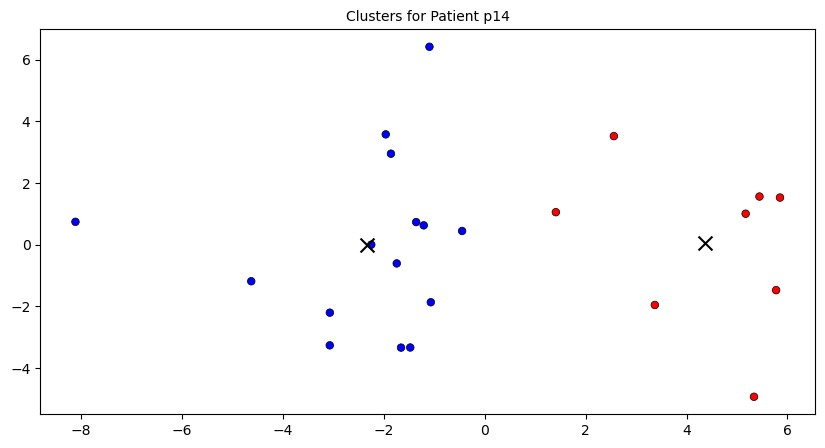

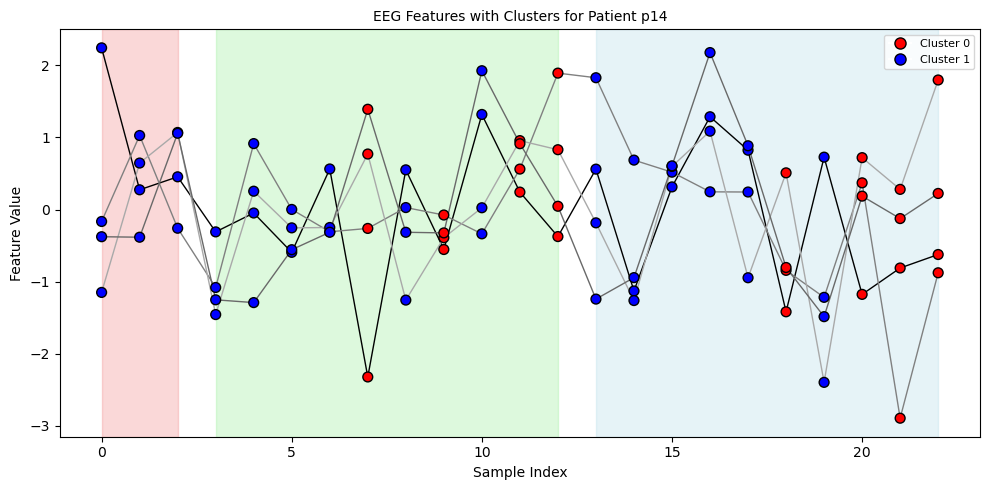

In [220]:
clustering_training_and_plotting('p14')